In [1]:
#IRAC forced photometry following Kristina Nylands python script using tractor


In [2]:
import numpy as np
import pandas as pd

from tractor import *
#from tractor import NCircularGaussianPSF, NullWCS, NullPhotoCal, ConstantSky, PixPos,Flux,GalaxyShape, PointSource
from tractor.mix import *
from tractor.galaxy import *
from tractor.sersic import *

from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import seaborn as sns

from astropy.nddata import Cutout2D
from astropy.stats import sigma_clipped_stats
import astropy.wcs as wcs
import astropy.io.fits as fits

import math

import sys
import os
from contextlib import contextmanager

!{sys.executable} -m pip install -U reproject
from reproject import reproject_interp

from skimage.transform import rotate



You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [3]:
# set up clean catalog with fiducial band fluxes, ra, dec, shape parameters, probability that it is a star

#read in the catalog I generated from IRSA website
#COSMOS 2015 with only some of the columns and a few rows
#Type: 0 = galaxy, 1 = star, 2 = X-ray source
#I think the center of this catalog is roughy 149.955, 3.5375
df = pd.read_csv('table_irsa_catalog_search_results.csv')

# set default cutout width = 10"
cutout_width = 10

ra_0 = df.ra[0]
dec_0 = df.dec[0]

In [4]:
#are there missing values
df.isna().sum()

#don't mind that there are missing values for IRAC flues or for photzs.  
#The rest of the rows are complete

ra                     0
dec                    0
ks_flux_aper2          0
ks_fluxerr_aper2       0
splash_1_flux          0
splash_1_flux_err      0
splash_2_flux          4
splash_2_flux_err      4
splash_3_flux          1
splash_3_flux_err      1
splash_4_flux          1
splash_4_flux_err      1
photoz               103
type                   0
dist                   0
angle                  0
dtype: int64

In [5]:
#ot of curiosity how many stars vs. galaxies vs. x ray sources
df.type.value_counts()

0    233
1     26
2     18
Name: type, dtype: int64

In [6]:
# initialize columns in data frame for photometry results
df[["ch1flux","ch1flux_unc","ch2flux","ch2flux_unc","ch3flux","ch3flux_unc","ch4flux","ch4flux_unc"]] = 0.0
df

,ra,dec,ks_flux_aper2,ks_fluxerr_aper2,splash_1_flux,splash_1_flux_err,splash_2_flux,splash_2_flux_err,splash_3_flux,splash_3_flux_err,...,dist,angle,ch1flux,ch1flux_unc,ch2flux,ch2flux_unc,ch3flux,ch3flux_unc,ch4flux,ch4flux_unc
0,149.965822,2.531597,214.326,0.206,125.964,1.339,86.027,0.624,53.593,6.518,...,20.980209,139.071517,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,149.959803,2.545853,200.022,0.202,229.210,0.663,213.566,0.649,133.877,8.212,...,36.338671,347.444316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,149.964342,2.524065,39.683,0.201,101.392,0.391,84.348,0.305,56.682,5.627,...,43.783967,168.908324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,149.974577,2.535126,179.502,0.202,178.545,0.980,159.020,0.583,93.677,8.478,...,45.342368,93.978393,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,149.964045,2.549669,554.188,0.215,265.029,4.806,167.963,1.731,122.502,9.193,...,49.755392,8.501218,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,149.947733,2.617537,784.587,0.211,403.274,5.183,268.914,4.217,176.142,9.653,...,297.982940,350.085037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
273,149.967699,2.618600,117.667,0.201,118.720,0.556,107.478,0.372,70.513,5.605,...,298.065477,3.942609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
274,150.029173,2.584542,3868.596,0.142,2222.299,25.874,1550.527,20.617,1050.171,37.954,...,298.160103,54.117628,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
275,149.986724,2.615151,1015.520,0.207,587.694,6.929,402.288,3.112,267.335,8.117,...,298.492791,17.330013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
#function to determine what type of source it is from catalog
def determine_source_type(ra, dec, df_type, fid_flux, x1,y1):
    #make all sources point sources for now
    #use fiducial flux as first guess of source flux in different bands
        
    src = PointSource(PixPos(x1,y1), Flux(fid_flux))
    return src
    

In [8]:
##function to extract cutout image

def extract_cutout(infile, ra, dec, cutout_width):
    '''
    infile: mosaic containing catalog source
    outfile: cutout fits file of source
    ra: RA of source being modeled  
    dec: DEC of source being modeled  
    cutout_width: desired width of cutout in arcseconds
    '''
    if not os.path.isfile(infile):
        error_message = 'ERROR: FITS FILE {} NOT FOUND - ABORTING SCRIPT'.format(infile)
        sys.exit(error_message)
    else:
        try:
            #open the mosaic file
            hdulist = fits.open(infile)[0]
            hdr = hdulist.header
            wcs_info = wcs.WCS(hdulist)
            
            #convert ra and dec into x, y 
            x0, y0 = wcs_info.all_world2pix(ra, dec,1)
            position=(x0, y0)
            #subimage = hdulist[0].data
            
            #make size array in pixels
            #how many 0.6" pixels in cutout_width
            mosaic_pix_scale = 0.6 #arseconds/pixel is the standard mosaic pixel scale
            size = (cutout_width / mosaic_pix_scale)
            size = int(math.ceil(size)) #round up the nearest integer
            
            #make the cutout
            cutout = Cutout2D(hdulist.data, position, size, copy = True, mode = "trim", wcs = wcs_info)
            subimage = cutout.data.copy()
            subimage_wcs = cutout.wcs.copy()
            
            #now need to set the values of x1, y1 at the location of the target *in the cutout*          
            x1, y1 = subimage_wcs.all_world2pix(ra, dec,1)
            #print('x1, y1', x1, y1)
            
            #hdulist.close()
            nodata_param = False
            
        except:
            nodata_param = True
            subimage = np.empty([10,10])
            subimage[:] = 0.0
            x1= 5
            y1= 5
            subimage_wcs = "extract cutout didn't work"
    return subimage.data, hdr, nodata_param, x1, y1, subimage_wcs



In [9]:
#function to make the PRF the same pixel scale as the mosaic images
#tractor expects this, and will give bad results if the pixel scale is anything else
def prepare_PRF(prf_fitsname, ra_0, dec_0, rotate_angle):
    
    #read in the PRF fits file
    ext_prf =  fits.open(prf_fitsname)[0]

    #fix a type on the header that crashes reproject_interp 
    ext_prf.header['CTYPE1'] = 'RA---TAN'
    
    #ok, need to fake it and make the ra and dec of the center of the prf 
    #be the same as the center of the cutout
    #just using a random cutout here to make this work since we need an image
    #for reproject_interp to work
    ext_prf.header['CRVAL1'] = ra_0
    ext_prf.header['CRVAL2'] = dec_0

    cutout = fits.open('0001_149.96582000_2.53160000_irac_ch1_go2_sci_10.fits')[0]

    prf_resample, footprint = reproject_interp(ext_prf, cutout.header)

    #ugg, ok, and check if it is an odd size
    #tractor crashes if the PRF has an even number of pixels
    if (len(prf_resample.data) % 2) < 1:
        prf_resample=Cutout2D(prf_resample, (9,9), (17,17)) 
    
        #and because cutout2D changes data types
        prf_resample = prf_resample.data
    
    #renormalize the PRF so that the sum of all pixels = 1.0
    #again, tractor gives anomolous results if the PRF is normalized any other way
    prf_resample_norm = prf_resample / prf_resample.sum()

    #looks like a rotation might help
    #still working to figure this out, but setting up to let it happen here
    prf_resample_norm_rotate = rotate(prf_resample_norm, rotate_angle)
       
    return prf_resample_norm_rotate



In [10]:
#function to figure out how many sources are in cutout
def find_nconfsources(raval, decval, gal_type, fluxval, x1, y1, cutout_width, subimage_wcs):
    
    #setup to collect sources
    objsrc = []
    
    #keep the main source
    objsrc.append(determine_source_type(raval, decval, gal_type, fluxval, x1, y1))
    
    #find confusing sources with real fluxes
    radiff = (df.ra-raval)*np.cos(decval)
    decdiff= df.dec-decval
    posdiff= np.sqrt(radiff**2+decdiff**2)*3600.
    det = df.ks_flux_aper2 > 0  #make sure they have fluxes
    
    #make an index into the dataframe for those objects within the same cutout
    good = (abs(radiff*3600.) < cutout_width/2) & (abs(decdiff*3600.) < cutout_width/2) & (posdiff > 0.2) & det
    nconfsrcs = np.size(posdiff[good])

    #add confusing sources
    #if there are any confusing sources
    if nconfsrcs > 0:
        ra_conf = df.ra[good].values
        dec_conf = df.dec[good].values
        flux_conf = df.ks_flux_aper2[good].values #should all be real fluxes
        type_conf = df.type[good].values

        for n in range(nconfsrcs):
            #now need to set the values of x1, y1 at the location of the target *in the cutout*          
            xn, yn = subimage_wcs.all_world2pix(ra_conf[n], dec_conf[n],1)
            objsrc.append(determine_source_type(ra_conf[n], dec_conf[n], type_conf[n], flux_conf[n], xn, yn))
                
            
    return objsrc, nconfsrcs
    
#calling sequence
#find_nconfsources(df.ra[i], df.dec[i], df.type[i], df.ks_flux_aper2[i], x1,y1, cutout_width, subimage_wcs)

In [11]:
#setup to supress output of tractor
#seems to be the only way to make it be quiet and not output every step of optimization
#https://stackoverflow.com/questions/2125702/how-to-suppress-console-output-in-python

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout


In [ ]:
#calculate an uncertainty as a combination of 
#tractor variance as reported by tractor
#background noise
#poisson noise
    

def calc_uncertainty(ch, flux, skynoise, tractor_std):
    #try putting everything in units of electrons to calculate the noise
    
    #clear up some variables first
    #cryo gain for 4 channels
    #think cosmos2015 is all cryo; really only matters for ch1
    cryo_gain = [3.3,3.7,3.8,3.8]  #electrons/DN
    
    #mosaic pixel scale
    pix_scale = 0.6 #arcseconds
    exptime = 3.8*60*60 #average exposure time in (s) over all IRAC data =3.8hrs from Laigle et al. 2016
    
    #fluxconv #from the headers or from the IRAC data handbook Table 4.2
    fluxconv = [0.1069, 0.1382, 0.5858, 0.2026]  #(MJy/sr) / (DN/s)
    
    #measurement area in pixels
    rad_prf = 3 #radius is 3 pixels, this is all a bit wishywashy
    A = pi*(rad_prf**2)  
    
    #-------------------
    #background noise
    #skynoise comes in with units of MJy/sr
    #need to work the area in here***
    bkg_electrons = sknoise * cryo_gain[ch]*exptime/flux_conv[ch]
    
    #------------------
    #poisson noise
    #flux comes in units of MJy/sr
    electrons = flux * cryo_gain[ch]*exptime/flux_conv[ch]
    poisson_noise = np.sqrt(electrons)
    
    #------------------
    #tractor uncertainty
    #comes in units of ???
    
    #------------------
    #add the uncertainties in quadrature
    unc = numpy.sqrt(bkg_noise**2 + poisson_noise**2 + tractor_std**2) 
    
    return unc

In [31]:
%%time
verbose = 0
rotate_angle = 0  #might want to rotate the PRF image - still needs testing

#set up prfs for each channel
prf_ch1 = prepare_PRF('IRAC.1.EXTPRF.5X.fits', ra_0, dec_0, rotate_angle)
prf_ch2 = prepare_PRF('IRAC.2.EXTPRF.5X.fits', ra_0, dec_0, rotate_angle)
prf_ch3 = prepare_PRF('IRAC.3.EXTPRF.5X.fits', ra_0, dec_0, rotate_angle)
prf_ch4 = prepare_PRF('IRAC.4.EXTPRF.5X.fits', ra_0, dec_0, rotate_angle)


#for each object in the catalog
for i in range(len(df)):

    #for each band
    for j in range(1,5):
        #print ("working on i", i, "j", j)
        #extract the cutout & choose prf
        if j == 1:
            infile = 'COSMOS_irac_ch1_mosaic_test.fits'
            prf = prf_ch1
            ch_flux = 'ch1flux'
            ch_unc = 'ch1flux_unc'
            splash_flux = df.splash_1_flux[i]
        elif j == 2:
            infile = 'COSMOS_irac_ch2_mosaic_test.fits'
            prf = prf_ch2
            ch_flux = 'ch2flux'
            ch_unc = 'ch2flux_unc'
            splash_flux = df.splash_2_flux[i]
        elif j == 3:
            infile = 'COSMOS_irac_ch3_mosaic_test.fits'
            prf = prf_ch3
            ch_flux = 'ch3flux'
            ch_unc = 'ch3flux_unc'
            splash_flux = df.splash_3_flux[i]
        elif j == 4:
            infile = 'COSMOS_irac_ch4_mosaic_test.fits'
            prf = prf_ch4
            ch_flux = 'ch4flux'
            ch_unc = 'ch4flux_unc'
            splash_flux = df.splash_4_flux[i]

        else:
            print("That band doesn't exist")
        
        
        #make a cutout
        subimage, hdr, nodata_param, x1,y1, subimage_wcs = extract_cutout(infile, df.ra[i], df.dec[i], cutout_width)
        
        #catch errors in making the cutouts
        if nodata_param == False:  #meaning we have data in the cutout
        
            #set up the source list
            #src = determine_source_type(df.ra[i], df.dec[i], df.type[i], df.ks_flux_aper2[i], x1,y1)
            objsrc, nconfsrcs = find_nconfsources(df.ra[i], df.dec[i], df.type[i], df.ks_flux_aper2[i], x1,y1, cutout_width, subimage_wcs)

            #measure sky noise and mean level
            skymean, skymedian, skynoise = sigma_clipped_stats(subimage, sigma=3.0)
        

            #make the tractor image
            tim=Image(data=subimage, invvar=np.ones_like(subimage) / skynoise**2, 
              psf=PixelizedPSF(prf) ,
              wcs=NullWCS(),photocal=NullPhotoCal(),sky=ConstantSky(skymean))
        
        
            # make tractor object
            tractor=Tractor([tim], objsrc) #[src]

            #freeze the parameters we don't want tractor fitting
            tractor.freezeParam('images') #fits 2 positions and flux
            #only fit for flux
            #src.freezeAllRecursive()
            #src.thawPathsTo('brightness')


            #run the tractor optimization (do forced photometry)
            # Take several linearized least squares steps
            fit_fail = False
            try:
                tr = 0
                with suppress_stdout():
                    for tr in range(20):
                        dlnp,X,alpha, flux_var=tractor.optimize(variance = True)
                        #print('dlnp',dlnp)
                        if dlnp < 1e-3:
                            break
            # catch exceptions and bad fits
            except:
                fit_fail = True
            
            
        
            # record the photometry results
            if fit_fail: 
                #tractor fit failed
                df.at[i,ch_flux]= np.nan
                df.at[i,ch_unc]= np.nan
            elif flux_var is None:  
                #fit worked, but flux variance did not get reported
                params_list=objsrc[0].getParamNames()
                bindex = params_list.index('brightness.Flux')
                flux = objsrc[0].getParams()[bindex]
                 #convert to microjanskies
                microJy_flux = flux *(1E12) / (4.254517E10) * (0.6) *(0.6)
                df.at[i,ch_flux]= microJy_flux
                df.at[i,ch_unc]= np.nan
            else: 
                #fit and variance worked
                params_list=objsrc[0].getParamNames()
                bindex = params_list.index('brightness.Flux')
                flux = objsrc[0].getParams()[bindex]
                # determine flux uncertainty
                #which value of flux_var is for the flux variance?
                fv = ((nconfsrcs+1)*3) - 1
                tractor_std = np.sqrt(flux_var[fv])  #so long as we are fitting all three parameters
                #convert to microjanskies
                microJy_flux = flux *(1E12) / (4.254517E10) * (0.6) *(0.6)
                microJy_unc = tractor_std *(1E12) / (4.254517E10) * (0.6) *(0.6)
                df.at[i,ch_flux]= microJy_flux
                df.at[i,ch_unc]= microJy_unc
                
                
                
            if verbose == 1:
            
                print("the tractor flux of the source is", microJy, 'MicroJy')
                print("The splash flux of the source is", splash_flux,'MicroJy')

                #look at residual images
                # Get the fit model and residual images for plotting
                mod=tractor.getModelImage(0)
                chi = tractor.getChiImage(0)
                diff=subimage-mod

                fig=plt.figure(figsize=(7,2))

                ax1=fig.add_subplot(131,autoscale_on=False,xlim=(0,17),ylim=(0,17))
                ax2=fig.add_subplot(132,autoscale_on=False,xlim=(0,17),ylim=(0,17))
                ax3=fig.add_subplot(133,autoscale_on=False,xlim=(0,17),ylim=(0,17))

                ax1.set(xticks=[],yticks=[])
                ax2.set(xticks=[],yticks=[])
                ax3.set(xticks=[],yticks=[])

                im1=ax1.imshow(subimage,cmap='gray')#, vmin = 0.01, vmax = 0.20
                ax1.set_title('Original Image')
                fig.colorbar(im1, ax= ax1)

                im2=ax2.imshow(mod,cmap='gray')#, vmin = 0.01, vmax = 0.20
                ax2.set_title('Model')
                fig.colorbar(im2, ax = ax2)

                im3 = ax3.imshow(diff,cmap = 'gray')#, vmin = 0.01, vmax = 0.20
                ax3.set_title('Residual')
                fig.colorbar(im3, ax = ax3)



/opt/conda/lib/python3.8/site-packages/tractor-git-py3.8-linux-x86_64.egg/tractor/lsqr_optimizer.py:666: RuntimeWarning: divide by zero encountered in true_divide
  return X, 1./np.array(var)
/opt/conda/lib/python3.8/site-packages/tractor-git-py3.8-linux-x86_64.egg/tractor/lsqr_optimizer.py:666: RuntimeWarning: divide by zero encountered in true_divide
  return X, 1./np.array(var)
/opt/conda/lib/python3.8/site-packages/tractor-git-py3.8-linux-x86_64.egg/tractor/lsqr_optimizer.py:666: RuntimeWarning: divide by zero encountered in true_divide
  return X, 1./np.array(var)
/opt/conda/lib/python3.8/site-packages/tractor-git-py3.8-linux-x86_64.egg/tractor/lsqr_optimizer.py:666: RuntimeWarning: divide by zero encountered in true_divide
  return X, 1./np.array(var)
/opt/conda/lib/python3.8/site-packages/tractor-git-py3.8-linux-x86_64.egg/tractor/lsqr_optimizer.py:666: RuntimeWarning: divide by zero encountered in true_divide
  return X, 1./np.array(var)
/opt/conda/lib/python3.8/site-packages/t

CPU times: user 1min 1s, sys: 363 ms, total: 1min 1s
Wall time: 1min 8s


In [32]:
#just checking that df is getting filled in properly
df

,ra,dec,ks_flux_aper2,ks_fluxerr_aper2,splash_1_flux,splash_1_flux_err,splash_2_flux,splash_2_flux_err,splash_3_flux,splash_3_flux_err,...,dist,angle,ch1flux,ch1flux_unc,ch2flux,ch2flux_unc,ch3flux,ch3flux_unc,ch4flux,ch4flux_unc
0,149.965822,2.531597,214.326,0.206,125.964,1.339,86.027,0.624,53.593,6.518,...,20.980209,139.071517,122.670794,0.381143,81.851241,0.355205,53.021459,1.756686,29.483738,1.743375
1,149.959803,2.545853,200.022,0.202,229.210,0.663,213.566,0.649,133.877,8.212,...,36.338671,347.444316,138.601787,1.530716,125.014154,1.603914,83.214161,2.246154,305.349062,6.374972
2,149.964342,2.524065,39.683,0.201,101.392,0.391,84.348,0.305,56.682,5.627,...,43.783967,168.908324,78.666591,0.747092,64.712955,0.748196,41.672128,1.778408,34.775110,1.885969
3,149.974577,2.535126,179.502,0.202,178.545,0.980,159.020,0.583,93.677,8.478,...,45.342368,93.978393,130.249823,0.759296,115.347219,0.689841,80.302720,2.104691,360.104819,5.593528
4,149.964045,2.549669,554.188,0.215,265.029,4.806,167.963,1.731,122.502,9.193,...,49.755392,8.501218,254.329197,0.766023,161.238343,0.590853,99.138441,2.035204,56.208623,2.233423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,149.947733,2.617537,784.587,0.211,403.274,5.183,268.914,4.217,176.142,9.653,...,297.982940,350.085037,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
273,149.967699,2.618600,117.667,0.201,118.720,0.556,107.478,0.372,70.513,5.605,...,298.065477,3.942609,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
274,150.029173,2.584542,3868.596,0.142,2222.299,25.874,1550.527,20.617,1050.171,37.954,...,298.160103,54.117628,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
275,149.986724,2.615151,1015.520,0.207,587.694,6.929,402.288,3.112,267.335,8.117,...,298.492791,17.330013,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [29]:
#how many rows did get filled in?  = 225
df_fill = df[df.ch1flux > 0]
df_fill

,ra,dec,ks_flux_aper2,ks_fluxerr_aper2,splash_1_flux,splash_1_flux_err,splash_2_flux,splash_2_flux_err,splash_3_flux,splash_3_flux_err,...,dist,angle,ch1flux,ch1flux_unc,ch2flux,ch2flux_unc,ch3flux,ch3flux_unc,ch4flux,ch4flux_unc
0,149.965822,2.531597,214.326,0.206,125.964,1.339,86.027,0.624,53.593,6.518,...,20.980209,139.071517,122.670794,0.381143,81.851241,0.355205,53.021459,1.756686,29.483738,1.743375
1,149.959803,2.545853,200.022,0.202,229.210,0.663,213.566,0.649,133.877,8.212,...,36.338671,347.444316,138.601787,1.530716,125.014154,1.603914,83.214161,2.246154,305.349062,6.374972
2,149.964342,2.524065,39.683,0.201,101.392,0.391,84.348,0.305,56.682,5.627,...,43.783967,168.908324,78.666591,0.747092,64.712955,0.748196,41.672128,1.778408,34.775110,1.885969
3,149.974577,2.535126,179.502,0.202,178.545,0.980,159.020,0.583,93.677,8.478,...,45.342368,93.978393,130.249823,0.759296,115.347219,0.689841,80.302720,2.104691,360.104819,5.593528
4,149.964045,2.549669,554.188,0.215,265.029,4.806,167.963,1.731,122.502,9.193,...,49.755392,8.501218,254.329197,0.766023,161.238343,0.590853,99.138441,2.035204,56.208623,2.233423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,149.914745,2.601328,87.336,0.215,76.787,0.596,74.180,0.371,45.389,4.926,...,290.158282,324.148511,58.399861,0.519605,55.282498,0.528150,34.553267,1.682343,124.822037,2.347951
265,149.886454,2.503615,22.303,0.225,50.433,0.232,45.979,0.195,22.863,3.940,...,295.657852,246.777914,43.564054,0.318893,38.915759,0.461211,26.212756,1.454421,19.583477,2.515829
266,149.891757,2.578780,25.457,0.218,59.644,0.385,77.289,0.338,89.563,2.911,...,295.865012,301.369602,75.942162,0.428412,89.228045,0.555859,93.772612,1.701122,121.579819,2.727966
267,149.898677,2.588578,409.916,0.224,192.008,1.331,126.138,1.514,85.972,8.404,...,296.126342,309.732714,189.096111,0.413502,126.878745,0.427480,80.094272,1.844383,43.832399,2.092925


CPU times: user 759 ms, sys: 16 ms, total: 775 ms
Wall time: 771 ms


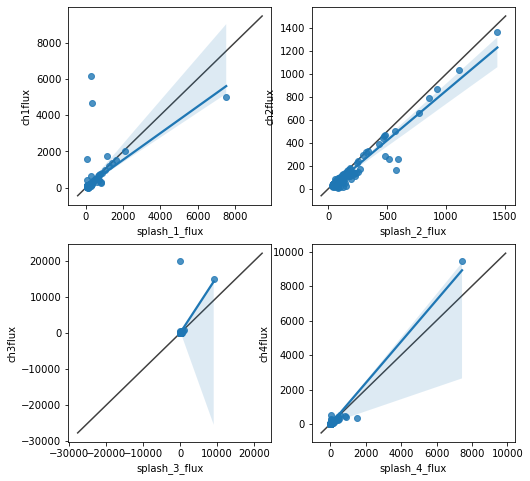

In [30]:
%%time
#plot tractor fluxes vs. catalog splash fluxes
#and hope I see a straightline with a slope of 1
#using sns regplot which plots both the data and a linear regression model fit
#need to still add uncertainties to the plotting and regression


#setup to plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

#ch1 
#first shrink the dataframe to only those rows where I have tractor photometry while testing
df_tractor = df[df.ch1flux> 0]
sns.regplot(data = df_tractor, x = "splash_1_flux", y = "ch1flux", ax = ax1)
#add a diagonal line with y = x
lims = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
    np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax1.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

#ch2 
#first shrink the dataframe to only those rows where I have tractor photometry while testing
df_tractor = df[df.ch2flux> 0]
sns.regplot(data = df_tractor, x = "splash_2_flux", y = "ch2flux", ax = ax2)
#add a diagonal line with y = x
lims = [
    np.min([ax2.get_xlim(), ax2.get_ylim()]),  # min of both axes
    np.max([ax2.get_xlim(), ax2.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax2.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

#ch3 
#first shrink the dataframe to only those rows where I have tractor photometry while testing
df_tractor = df[df.ch3flux> 0]

sns.regplot(data = df_tractor, x = "splash_3_flux", y = "ch3flux", ax = ax3)
#add a diagonal line with y = x
lims = [
    np.min([ax3.get_xlim(), ax3.get_ylim()]),  # min of both axes
    np.max([ax3.get_xlim(), ax3.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax3.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

#ch4 
#first shrink the dataframe to only those rows where I have tractor photometry while testing
df_tractor = df[df.ch4flux> 0]

sns.regplot(data = df_tractor, x = "splash_4_flux", y = "ch4flux", ax = ax4)
#add a diagonal line with y = x
lims = [
    np.min([ax4.get_xlim(), ax4.get_ylim()]),  # min of both axes
    np.max([ax4.get_xlim(), ax4.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax4.plot(lims, lims, 'k-', alpha=0.75, zorder=0)





fig.set_size_inches(8, 8)